# single patch conv net  

this notebook it an attempt to solve some of the issues being encountered on the full size network by reducing the size of the problem to learn the SSIM score for a single patch of each image (using the upper left most pixels). in principle this task should be identical to what the larger net is trying to do but should give some insight into what is going on.

In [1]:
#!/usr/bin/env python3
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
import numpy as np
np.set_printoptions(threshold=np.nan)
import tensorflow as tf
import time
import pandas as pd
import matplotlib.pyplot as plt
import progressbar

### network functions

In [2]:
def convolve_inner_layers(x, W, b):
    y = tf.nn.conv2d(x, W, strides = [1,1,1,1], padding='VALID')
    y = tf.nn.bias_add(y, b)
    return tf.nn.tanh(y)

def convolve_ouput_layer(x, W, b):
    y = tf.nn.conv2d(x, W, strides = [1,1,1,1], padding='VALID')
    y = tf.nn.bias_add(y, b)
    return y

def conv_net(x, W, b):
    conv1 = convolve_inner_layers(x, W['weights1'], b['bias1'])
    conv2 = convolve_inner_layers(conv1, W['weights2'], b['bias2'])
    conv3 = convolve_inner_layers(conv2, W['weights3'], b['bias3'])
    output_feed = tf.concat([conv1, conv2, conv3],3)
    output = convolve_ouput_layer(output_feed, W['weights_out'], b['bias_out'])
    return output

### data processing functions

In [3]:
def get_variance(training_target):
    all_pixels = training_target.flatten()
    return all_pixels.var()

def get_epoch(x, y, n):
    input_size = x.shape[0]
    number_batches = input_size // n
    extra_examples = input_size % n
    batches = {}
    batch_indices = np.arange(input_size)
    np.random.shuffle(batch_indices)
    for i in range(number_batches):
        temp_indices = batch_indices[n*i:n*(i+1)]
        temp_x = []
        temp_y = []
        for j in temp_indices:
            temp_x.append(x[j])
            temp_y.append(y[j])
        batches[i] = [np.asarray(temp_x), np.asarray(temp_y)]
    if extra_examples != 0:
        extra_indices = batch_indices[input_size-extra_examples:input_size]
        temp_x = []
        temp_y = []
        for k in extra_indices:
            temp_x.append(x[k])
            temp_y.append(y[k])
        batches[i+1] = [np.asarray(temp_x), np.asarray(temp_y)]
    return batches

def normalize_input(train_data, test_data):
    mean, std_dev = np.mean(train_data, axis=0), np.std(train_data, axis=0)
    return (train_data - mean) / std_dev, (test_data - mean) / std_dev

def calculate_ssim(window_orig, window_recon):
    k_1 = 0.01
    k_2 = 0.03
    L = 255
    if window_orig.shape != (11,11) or window_recon.shape != (11,11):
        raise ValueError('please check window size for SSIM calculation!')
    orig_data = window_orig.flatten()
    recon_data = window_recon.flatten()
    mean_x = np.mean(orig_data)
    mean_y = np.mean(recon_data)
    var_x = np.var(orig_data)
    var_y = np.var(recon_data)
    covar = np.cov(orig_data, recon_data)[0][1]
    c_1 = (L*k_1)**2
    c_2 = (L*k_2)**2
    num = (2*mean_x*mean_y+c_1)*(2*covar+c_2)
    den = (mean_x**2+mean_y**2+c_1)*(var_x+var_y+c_2)
    return num/den

### network set up

In [4]:
# network parameters
filter_dim, filter_dim2 = 11, 1
batch_size = 200
image_dim, result_dim = 96, 86
input_layer, first_layer, second_layer, third_layer, output_layer = 4, 17, 9, 4, 1
learning_rate = .01
epochs = 300

In [5]:
# data input
data_path = 'https://raw.githubusercontent.com/michaelneuder/image_quality_analysis/master/data/sample_data/'

# train data --- 500 images, 96x96 pixels
orig_500 = pd.read_csv('{}orig_500.txt'.format(data_path), header=None, delim_whitespace = True)
recon_500 = pd.read_csv('{}recon_500.txt'.format(data_path), header=None, delim_whitespace = True)

# test data --- 140 images, 96x96 pixels
orig_140 = pd.read_csv('{}orig_140.txt'.format(data_path), header=None, delim_whitespace = True)
recon_140 = pd.read_csv('{}recon_140.txt'.format(data_path), header=None, delim_whitespace = True)

# train target --- 500 images, 86x86 pixels (dimension reduction due no zero padding being used)
ssim_500 = pd.read_csv('{}ssim_500_new.csv'.format(data_path), header=None).values
ssim_140 = pd.read_csv('{}ssim_140_new.csv'.format(data_path), header=None).values

In [6]:
# getting 4 input channels for train and test
original_images_train = orig_500.values
original_images_train_sq = orig_500.values**2
reconstructed_images_train = recon_500.values
reconstructed_images_train_sq = recon_500.values**2

original_images_test = orig_140.values
original_images_test_sq = orig_140.values**2
reconstructed_images_test = recon_140.values
reconstructed_images_test_sq = recon_140.values**2

# stack inputs
training_input = np.dstack((original_images_train, reconstructed_images_train, original_images_train_sq, reconstructed_images_train_sq))
testing_input = np.dstack((original_images_test, reconstructed_images_test, original_images_test_sq, reconstructed_images_test_sq))

# normalize inputs
training_input_normalized, testing_input_normalized = normalize_input(training_input, testing_input)

# get size of training and testing set
train_size = original_images_train.shape[0]
test_size = original_images_test.shape[0]

# reshaping
train_data = np.reshape(training_input_normalized, [train_size,image_dim,image_dim,input_layer])
test_data =  np.reshape(testing_input_normalized, [test_size,image_dim,image_dim,input_layer])

# reshaping the result data to --- (num pics), 86, 86, 1
train_target = np.reshape(ssim_500, [train_size, result_dim, result_dim, output_layer])
test_target = np.reshape(ssim_140, [test_size, result_dim, result_dim, output_layer])

### single patch set up

now that we have all the network data set up, we can just grab the top left corner (11x11 pixels) of each image.

In [7]:
single_train_data, single_test_data = train_data[:,:11,:11,:], test_data[:,:11,:11,:]

first we will do manual calculations of the ssim score. and compare that to the matlab data (read from file).

In [8]:
ssim_train, ssim_test = [], []
for i in range(train_size):
    ssim_train.append(calculate_ssim(single_train_data[i][...,0], single_train_data[i][...,1]))
    if i < 140:
        ssim_test.append(calculate_ssim(single_test_data[i][...,0], single_test_data[i][...,1]))

ssim_train = np.reshape(np.asarray(ssim_train), (train_size,1))
ssim_test = np.reshape(np.asarray(ssim_test), (test_size,1))

In [9]:
ssim_train.shape, ssim_test.shape

((500, 1), (140, 1))

In [10]:
single_train_data.shape

(500, 11, 11, 4)

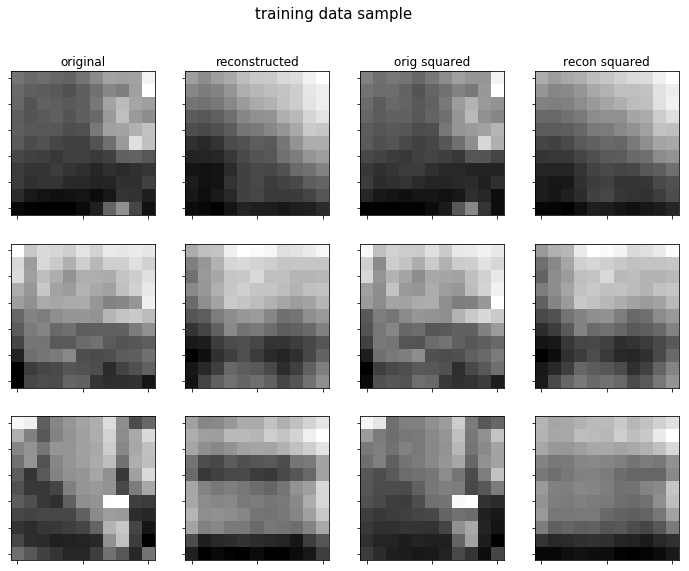

In [13]:
f, axarr = plt.subplots(nrows=3,ncols=4, figsize=(12,9))
for i in range(3):
    index = np.random.randint(500)
    axarr[i,0].imshow(single_train_data[index,:,:,0], cmap='gray')
    axarr[i,1].imshow(single_train_data[index,:,:,1], cmap='gray')
    axarr[i,2].imshow(single_train_data[index,:,:,2], cmap='gray')
    axarr[i,3].imshow(single_train_data[index,:,:,3], cmap='gray')

axarr[0,0].set_title('original')
axarr[0,1].set_title('reconstructed')
axarr[0,2].set_title('orig squared')
axarr[0,3].set_title('recon squared')
for ax_row in axarr:
    for ax in ax_row:
        ax.set_xticklabels([])
        ax.set_yticklabels([])

f.suptitle('training data sample', size=15)
plt.savefig('single_patch.png')
plt.show()

In [12]:
ssim_train_mat = np.reshape(train_target[:,0,0,0], [train_size,1])
ssim_test_mat = np.reshape(test_target[:,0,0,0], [test_size,1])
ssim_train_mat.shape, ssim_test_mat.shape

((500, 1), (140, 1))

In [13]:
x = ssim_test_mat - ssim_test
x.mean()

-0.44595500191836129

now we have the target values set up we can train the network with the python data.

In [14]:
# tensorflow graph set up
tf.reset_default_graph()

# initializing variables --- fan in
scaling_factor = 1.0
initializer = tf.contrib.layers.variance_scaling_initializer(factor=scaling_factor, mode='FAN_IN')
weights = {
    'weights1': tf.get_variable('weights1', [filter_dim,filter_dim,input_layer,first_layer], initializer=initializer),
    'weights2': tf.get_variable('weights2', [filter_dim2,filter_dim2,first_layer,second_layer], initializer=initializer),
    'weights3': tf.get_variable('weights3', [filter_dim2,filter_dim2,second_layer,third_layer], initializer=initializer),
    'weights_out': tf.get_variable('weights4', [filter_dim2,filter_dim2,third_layer+second_layer+first_layer,output_layer], initializer=initializer)
}
biases = {
    'bias1': tf.get_variable('bias1', [first_layer], initializer=initializer),
    'bias2': tf.get_variable('bias2', [second_layer], initializer=initializer),
    'bias3': tf.get_variable('bias3', [third_layer], initializer=initializer),
    'bias_out': tf.get_variable('bias4', [output_layer], initializer=initializer)
}

# tf Graph input
x = tf.placeholder(tf.float32, [None, filter_dim, filter_dim, input_layer])
y = tf.placeholder(tf.float32, [None, output_layer])

# model
prediction = conv_net(x, weights, biases)

# get variance to normalize error terms during training
variance = get_variance(train_target)

# loss and optimization
cost = tf.reduce_mean(tf.square(tf.subtract(prediction, y)))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [15]:
# session
init = tf.global_variables_initializer()
error_train, error_test = [], []
with tf.Session() as sess:
    sess.run(init)
    bar = progressbar.ProgressBar()
    for epoch_count in bar(range(epochs)):
        epoch = get_epoch(single_train_data, ssim_train, batch_size)
        for i in epoch:
            x_data_train, y_data_train = np.asarray(epoch[i][0]), np.asarray(epoch[i][1])
            sess.run(optimizer, feed_dict={x : x_data_train, y : y_data_train})
            loss = sess.run(cost, feed_dict={x : x_data_train, y : y_data_train})
            percent_error = 100*loss/variance
        error_train.append(percent_error)
        score = sess.run(cost, feed_dict={x: single_test_data, y: ssim_test})
        percent_error = 100*score/variance
        error_test.append(percent_error)

100% (300 of 300) |#######################| Elapsed Time: 0:00:03 Time: 0:00:03


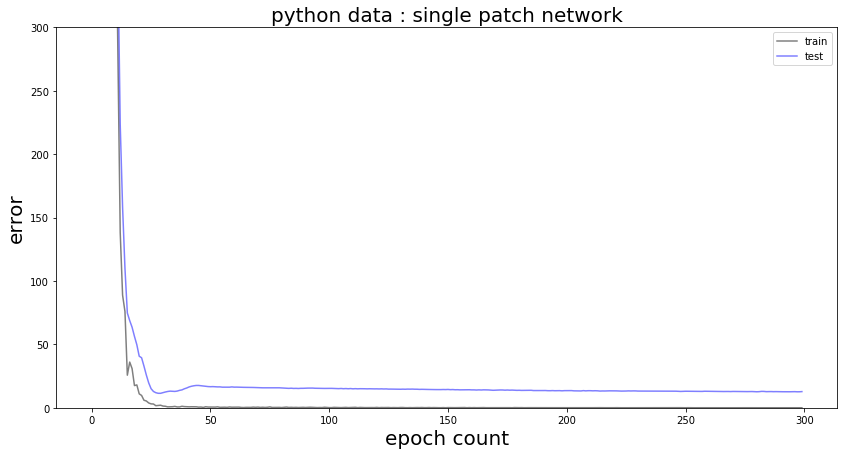

In [16]:
fig, ax = plt.subplots(figsize=(14,7))
ax.plot(np.arange(len(error_train)), error_train, label='train', color='k', alpha=0.5)
ax.plot(np.arange(len(error_test)), error_test, label='test', color='b', alpha=0.5)
ax.legend()
ax.set_ylim(0,300)
ax.set_ylabel('error', size=20)
ax.set_xlabel('epoch count', size=20)
ax.set_title('python data : single patch network', size=20)
# plt.savefig('python_single.png')
plt.show()

this looks great! now lets try it with the matlab data.

In [17]:
# tensorflow graph set up
tf.reset_default_graph()

# initializing variables --- fan in
scaling_factor = 1.0
initializer = tf.contrib.layers.variance_scaling_initializer(factor=scaling_factor, mode='FAN_IN')
weights = {
    'weights1': tf.get_variable('weights1', [filter_dim,filter_dim,input_layer,first_layer], initializer=initializer),
    'weights2': tf.get_variable('weights2', [filter_dim2,filter_dim2,first_layer,second_layer], initializer=initializer),
    'weights3': tf.get_variable('weights3', [filter_dim2,filter_dim2,second_layer,third_layer], initializer=initializer),
    'weights_out': tf.get_variable('weights4', [filter_dim2,filter_dim2,third_layer+second_layer+first_layer,output_layer], initializer=initializer)
}
biases = {
    'bias1': tf.get_variable('bias1', [first_layer], initializer=initializer),
    'bias2': tf.get_variable('bias2', [second_layer], initializer=initializer),
    'bias3': tf.get_variable('bias3', [third_layer], initializer=initializer),
    'bias_out': tf.get_variable('bias4', [output_layer], initializer=initializer)
}

# tf Graph input
x = tf.placeholder(tf.float32, [None, filter_dim, filter_dim, input_layer])
y = tf.placeholder(tf.float32, [None, output_layer])

# model
prediction = conv_net(x, weights, biases)

# get variance to normalize error terms during training
variance = get_variance(train_target)

# loss and optimization
cost = tf.reduce_mean(tf.square(tf.subtract(prediction, y)))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [18]:
# session
init = tf.global_variables_initializer()
error_train, error_test = [], []
with tf.Session() as sess:
    sess.run(init)
    bar = progressbar.ProgressBar()
    for epoch_count in bar(range(epochs)):
        epoch = get_epoch(single_train_data, ssim_train_mat, batch_size)
        for i in epoch:
            x_data_train, y_data_train = np.asarray(epoch[i][0]), np.asarray(epoch[i][1])
            sess.run(optimizer, feed_dict={x : x_data_train, y : y_data_train})
            loss = sess.run(cost, feed_dict={x : x_data_train, y : y_data_train})
            percent_error = 100*loss/variance
        error_train.append(percent_error)
        score = sess.run(cost, feed_dict={x: single_test_data, y: ssim_test_mat})
        percent_error = 100*score/variance
        error_test.append(percent_error)

100% (300 of 300) |#######################| Elapsed Time: 0:00:03 Time: 0:00:03


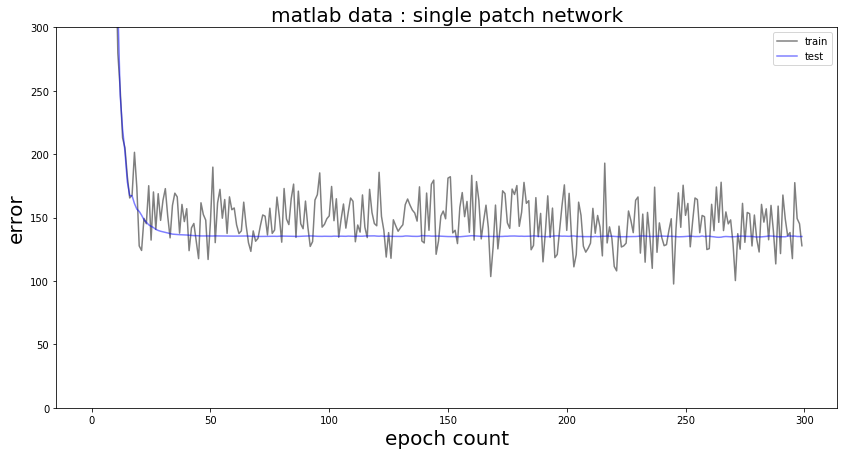

In [19]:
fig, ax = plt.subplots(figsize=(14,7))
ax.plot(np.arange(len(error_train)), error_train, label='train', color='k', alpha=0.5)
ax.plot(np.arange(len(error_test)), error_test, label='test', color='b', alpha=0.5)
ax.legend()
ax.set_ylim(0,300)
ax.set_ylabel('error', size=20)
ax.set_xlabel('epoch count', size=20)
ax.set_title('matlab data : single patch network', size=20)
plt.savefig('matlab_single.png')
plt.show()

not so great. this is not good


In [46]:
# lets compare the data from matlab and python.
ssim_140_py = pd.read_csv('{}SSIM_140.txt'.format(data_path), header=None, delim_whitespace=True).values
ssim_140_mat_ng = pd.read_csv('{}ssim_140_nogauss.csv'.format(data_path), header=None).values

In [47]:
ssim_140_py = np.reshape(ssim_140_py, (140,96,96))
ssim_140_mat_ng = np.reshape(ssim_140_mat_ng, (140,86,86))

In [49]:
ssim_140_mat_ng.shape, ssim_140_py.shape

((140, 86, 86), (140, 96, 96))

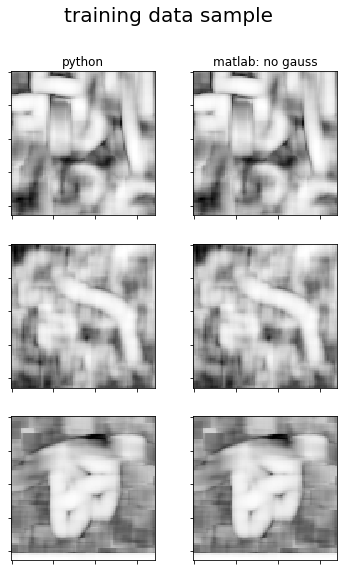

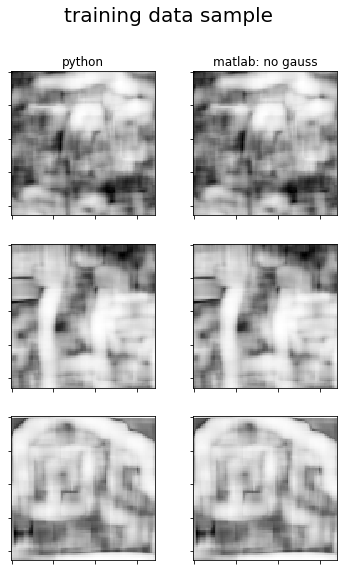

In [57]:
f, axarr = plt.subplots(nrows=3,ncols=2, figsize=(6,9))
for i in range(3):
    index = np.random.randint(140)
    axarr[i,0].imshow(ssim_140_py[index,5:91,5:91], cmap='gray')
    axarr[i,1].imshow(ssim_140_mat_ng[index,:,:], cmap='gray')
    
axarr[0,0].set_title('python')
axarr[0,1].set_title('matlab: no gauss')
for ax_row in axarr:
    for ax in ax_row:
        ax.set_xticklabels([])
        ax.set_yticklabels([])

f.suptitle('training data sample', size=20)
plt.savefig('data_comp.png')
plt.show()

In [53]:
diff = ssim_140_py[index,5:91,5:91]-ssim_140_mat_ng[index,:,:]
diff.mean()

0.006488372498647919